# Trénovanie modelu na základe DST indexu, F10_indexu a BZ_GSM 3h dopredu 6 dozadu
Súbor: 6_3_pridane_atr.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 21.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 25.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard

### Kontrola kapacity servera

In [2]:
!nvidia-smi

Mon Mar 13 22:42:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:8B:00.0 Off |                  N/A |
| 30%   35C    P0    40W / 125W |    912MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [4]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
           'DST',
            'F10_INDEX',
            'BZ_GSM',
            'DST+3']
test = test[features]
train = train[features]
train = train.dropna()
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST+3'
predicators = ['DST',
            'F10_INDEX',
            'BZ_GSM']

y_col='DST+3'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[predicators].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[predicators].values.copy()
y_test = test[y_col].values.copy()
X_test = test[predicators].values.copy()

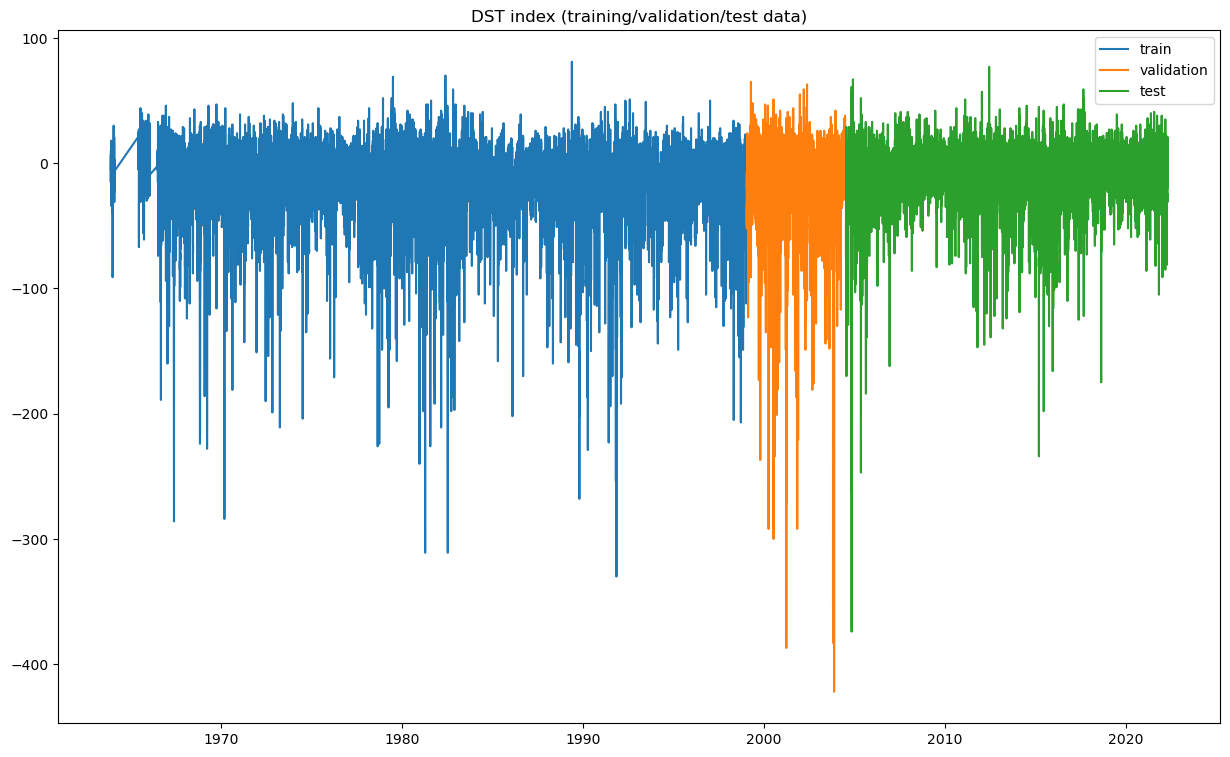

In [4]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST+2'],label='train')
plt.plot(valid['time1'],valid['DST+2'],label='validation')
plt.plot(test['time1'],test['DST+2'],label='test')
plt.legend();

In [5]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [6]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  753
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [7]:
inputs = Input(shape=(6,3)) #(kolko hodinove je okno, kolko je features v train)
c = Bidirectional((LSTM(128, input_shape=(X_train.shape[0], X_train.shape[1]), return_sequences=True, dropout=0.1,recurrent_dropout=0.1)))(inputs)
c = LSTM(128, input_shape=(X_train.shape[0], X_train.shape[1]), return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-03-13 22:43:08.796008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5765 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:8b:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           135168    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [8]:
inputs = Input(shape=(n_input,1))
b = Conv1D(128, kernel_size = 4, padding = "same")(inputs)
b = Bidirectional(LSTM(128, dropout=0.1,recurrent_dropout=0.1))(inputs)
b = Dense(64, activation='relu')(b)
b = Dropout(0.2)(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              133120    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                           

In [88]:
inputs = Input(shape=(6,3)) #(kolko hodinove je okno, kolko je features v train)
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(3, activation='linear'))(c)
output = Flatten()(c)
output = Dense(3, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 6, 256)           135168    
 nal)                                                            
                                                                 
 lstm_10 (LSTM)              (None, 6, 128)            197120    
                                                                 
 time_distributed_3 (TimeDis  (None, 6, 3)             387       
 tributed)                                                       
                                                                 
 flatten_3 (Flatten)         (None, 18)                0         
                                                                 
 dense_16 (Dense)            (None, 3)                 57  

In [8]:
# callbacks
saved_model = "6_3_pridane_atr.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [9]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2023-03-13 22:43:38.423434: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


753/753 [==============================] - ETA: 0s - loss: 110.2738 - mae: 4.7096
Epoch 1: val_mae improved from inf to 5.21830, saving model to 6_3_pridane_atr.hdf5
753/753 [==============================] - 53s 60ms/step - loss: 110.2738 - mae: 4.7096 - val_loss: 118.8606 - val_mae: 5.2183
Epoch 2/20
753/753 [==============================] - ETA: 0s - loss: 39.0309 - mae: 2.9290
Epoch 2: val_mae improved from 5.21830 to 3.12470, saving model to 6_3_pridane_atr.hdf5
753/753 [==============================] - 44s 59ms/step - loss: 39.0309 - mae: 2.9290 - val_loss: 62.9242 - val_mae: 3.1247
Epoch 3/20
753/753 [==============================] - ETA: 0s - loss: 31.5687 - mae: 2.6535
Epoch 3: val_mae did not improve from 3.12470
753/753 [==============================] - 44s 59ms/step - loss: 31.5687 - mae: 2.6535 - val_loss: 54.0288 - val_mae: 3.8052
Epoch 4/20
753/753 [==============================] - ETA: 0s - loss: 25.9507 - mae: 2.5544
Epoch 4: val_mae improved from 3.12470 to 2.909

In [10]:
# load best model
model = keras.models.load_model('6_3_pridane_atr.hdf5')

In [11]:
# prediction
y_pred = model.predict(test_generator)

607/607 [==============================] - 10s 14ms/step


In [12]:
y_pred

array([[ 14.873293],
       [ 14.272533],
       [ 13.48572 ],
       ...,
       [-24.617958],
       [-27.09022 ],
       [-27.857416]], dtype=float32)

In [13]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[124588     49]
 [  4337  26279]]


In [14]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    124637
           1       1.00      0.86      0.92     30616

    accuracy                           0.97    155253
   macro avg       0.98      0.93      0.95    155253
weighted avg       0.97      0.97      0.97    155253



In [15]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [16]:
df

,time,y_true,y_predict
6,2004-07-22 04:00:00,14.0,14.873293
7,2004-07-22 05:00:00,14.0,14.272533
8,2004-07-22 06:00:00,14.0,13.485720
9,2004-07-22 07:00:00,11.0,11.757072
10,2004-07-22 08:00:00,11.0,10.964727
...,...,...,...
155254,2022-04-28 20:00:00,-18.0,-17.600590
155255,2022-04-28 21:00:00,-23.0,-21.741165
155256,2022-04-28 22:00:00,-26.0,-24.617958
155257,2022-04-28 23:00:00,-29.0,-27.090219


In [17]:
df.describe()

,y_true,y_predict
count,155253.000000,155253.000000
mean,-9.817176,-9.377975
std,16.339982,14.911595
min,-374.000000,-230.244110
25%,-16.000000,-15.614975
50%,-7.000000,-7.147915
75%,0.000000,-0.207712
max,77.000000,50.555195


<AxesSubplot: >

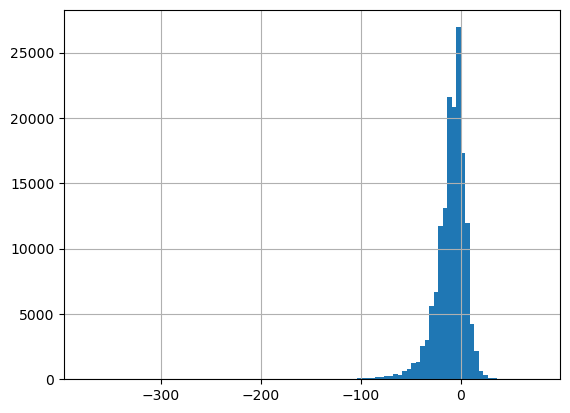

In [18]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

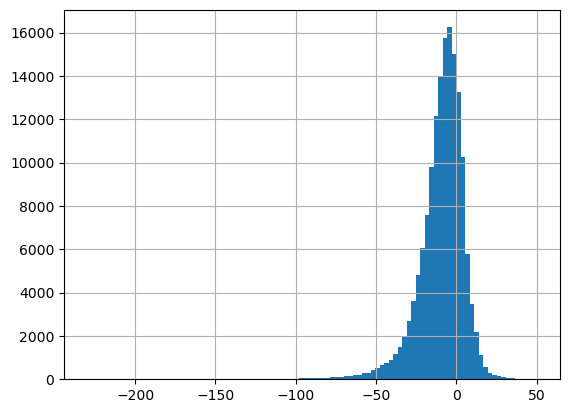

In [19]:
df["y_predict"].hist(bins=100)

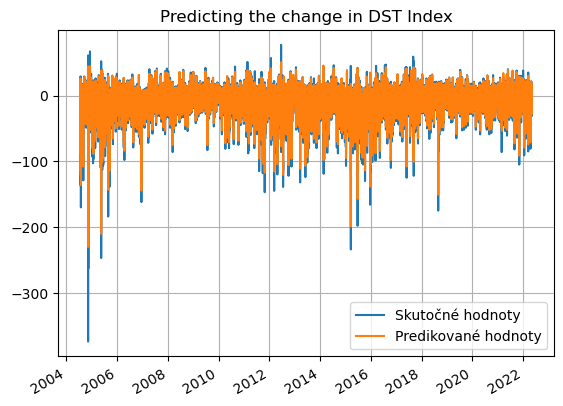

In [20]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [21]:
df.to_csv('predikcie_6_3_prid_atr.csv')

In [22]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[124588     49]
 [  4337  26279]]


In [23]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)

124588
49
4337
26279


In [24]:
from sklearn.metrics import *
TN = cm[0,0] 
print("TN={}".format(TN))
FP = cm[0,1]
print("FP={}".format(FP))
FN = cm[1,0] 
print("FN={}".format(FN))
TP = cm[1,1] 
print("TP={}".format(TP))
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
fpr, tpr, threshold = roc_curve(y_test2, y_pred2)
AUC = auc(fpr, tpr)
print("AUC={}".format(AUC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

TN=124588
FP=49
FN=4337
TP=26279
TPR=0.8583420433760125
TNR=0.9996068583165513
PPV=0.9981388635673047
NPV=0.9663602869885592
FPR=0.0003931416834487351
FNR=0.14165795662398745
FDR=0.0018611364326952295
ACC=0.97174933817704
AUC=0.9289744508462819
MCC=0.909665315873269
